<a href="https://colab.research.google.com/github/MahdiFaourr/MahdiFaourr/blob/main/Diabetes_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install gradio==3.14.0

In [ ]:
# Import necessary libraries, functions and classes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import opendatasets as od
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import gradio as gr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score
import joblib

In [ ]:
# Download the data from kaggle
od.download("https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database")

In [ ]:
# Read the data in a pandas dataframe
data=pd.read_csv("/content/pima-indians-diabetes-database/diabetes.csv")

In [ ]:
# Display a subpart of the data
data.head()

In [ ]:
# Data-shape
data.shape

In [ ]:
# Search for nulls
data.isnull().sum()

In [ ]:
# Data-info
data.info()

In [ ]:
# Check the number of samples in each class
data['Outcome'].value_counts()

In [ ]:
# Create two sub datas each one represents a class
data_1=data[data['Outcome']==1]
data_0=data[data['Outcome']==0]

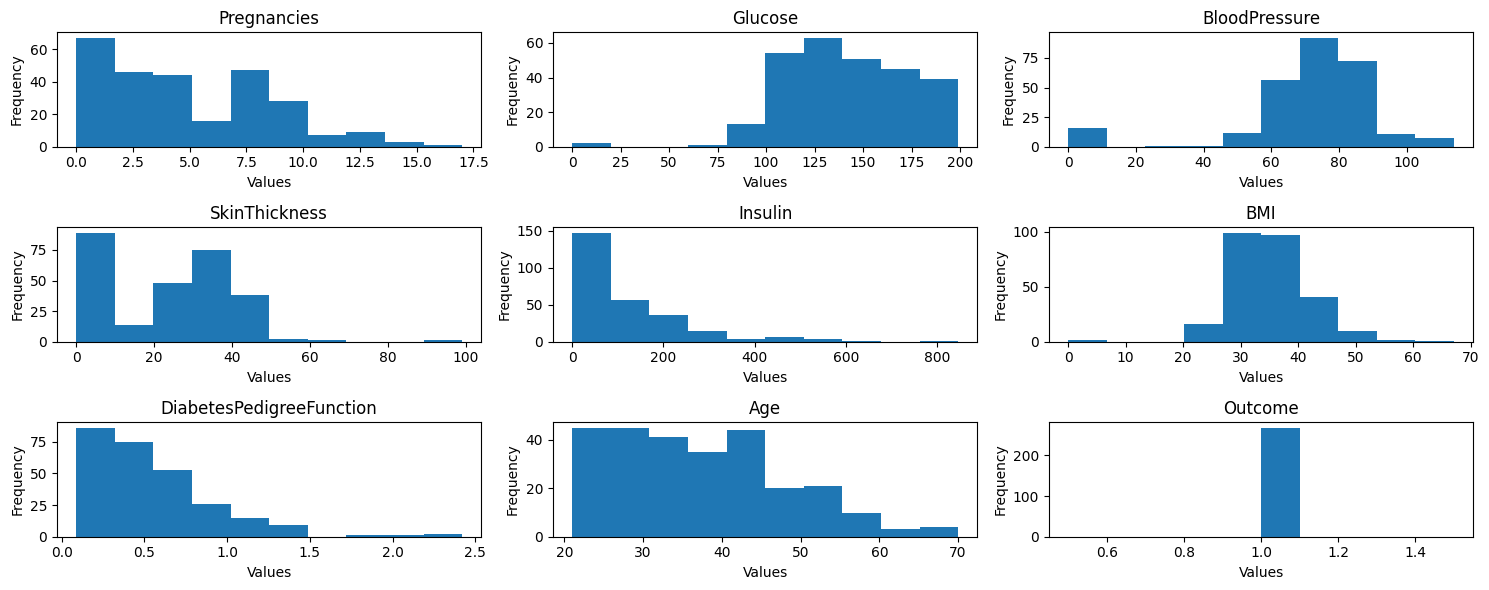

In [ ]:
# Create subplots with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()
# Loop through each column and plot a histogram in the corresponding subplot
for i, column in enumerate(data_1.columns):
     axes[i].hist(data_1[column], bins=10)
     axes[i].set_title(column)
     axes[i].set_xlabel('Values')
     axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()



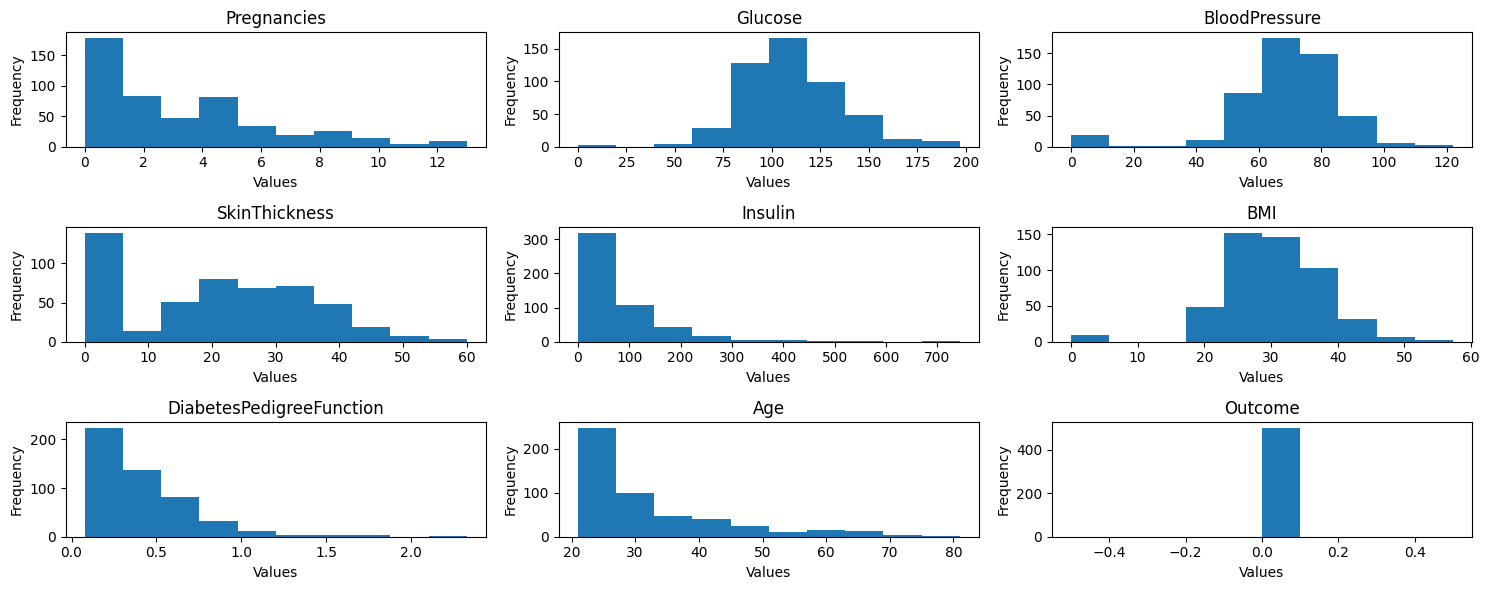

In [ ]:
# Create subplots with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()
# Loop through each column and plot a histogram in the corresponding subplot
for i, column in enumerate(data_1.columns):
     axes[i].hist(data_0[column], bins=10)
     axes[i].set_title(column)
     axes[i].set_xlabel('Values')
     axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Over sample the minor class
x=data.drop(['Outcome'],axis=1).values
y=data['Outcome'].values
over=RandomOverSampler(sampling_strategy=1)
x_new,y_new=over.fit_resample(x,y)
# Split the data into training and testing parts
x_train,x_test,y_train,y_test=train_test_split(x_new,y_new,test_size=0.2,random_state=42)

In [ ]:
# Initialize some classical models
lr=LogisticRegression()
svc=SVC()
tree=DecisionTreeClassifier()
forest=RandomForestClassifier()
adab=AdaBoostClassifier()
models=[lr,svc,tree,forest,adab]
# Iterate over the models and perform cross validation for each one
for model in models:
  print("".join('-' for x in range(50)))
  print(f".{model}:")
  scores=cross_validate(model,x_new,y_new,cv=3,scoring=['accuracy','precision','recall'])
  print("Accuracy %:", np.mean(scores['test_accuracy'])*100)
  print("Precision %:", np.mean(scores['test_accuracy'])*100)
  print("Recall %:", np.mean(scores['test_accuracy'])*100)


In [ ]:
# Create a dictionary for GridSearchCV-usage
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Create the GridSearchCV object and use the model with best performance
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid,
                           scoring='accuracy', cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(x_new, y_new)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
# Train the fine tuned model
x_train,x_test,y_train,y_test=train_test_split(x_new,y_new,test_size=0.2,random_state=42)
forest=RandomForestClassifier(max_depth=None,min_samples_leaf=1,min_samples_split=2,n_estimators=50)
forest.fit(x_train,y_train)
y_hat=forest.predict(x_test)

In [ ]:
# Check the performance of the model
print("accuracy%:",accuracy_score(y_hat,y_test)*100)
print("precision%:",precision_score(y_hat,y_test)*100)
print("recall%:",recall_score(y_hat,y_test)*100)

accuracy%: 81.5
precision%: 85.14851485148515
recall%: 79.62962962962963


In [ ]:
# Save the model
joblib.dump(forest, 'diabetes_forest_model.joblib')

['diabetes_forest_model.joblib']

In [ ]:
def diagnosis(input_features):
    # Ensure that the input has the correct number of features
    if len(input_features) != 8:
        return "Error: Input should contain 8 features"

    # Convert input features to numpy array and scale them
    input_features_array = np.array(input_features).reshape(1, -1)  # Reshape to a single sample
    # Make predictions using the trained model
    prediction = forest.predict(input_features_array)

    # Return the diagnosis based on the prediction
    if prediction == 0:
        return "Negative"
    elif prediction == 1:
        return "Positive"
    else:
        return "Error: Invalid prediction"


In [ ]:
# Example usage 1
input_features =[6,	148,	72,	35,	0,	33.6,	0.627,	50]
result = diagnosis(input_features)
print("Diagnosis:", result)

Diagnosis: Positive


In [ ]:
# Example usage 2
input_features =[1,	85,	66,	29,	0,	26.6,	0.351,	31	]
result = diagnosis(input_features)
print("Diagnosis:", result)

Diagnosis: Negative


In [ ]:
def gr_function(feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8):
    # Convert input features to numpy array and reshape
    input_features_array = np.array([feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8]).reshape(1, -1)

    # Make predictions using the trained model
    prediction = forest.predict(input_features_array)

    # Return the diagnosis based on the prediction
    if prediction == 0:
        return "Negative"
    elif prediction == 1:
        return "Positive"
    else:
        return "Error: Invalid prediction"

# Create Gradio interface
input_features = [gr.inputs.Number(label=f"{i}") for i in data.drop('Outcome',axis=1).columns]
output_text = gr.outputs.Textbox(label="Diagnosis")
gr.Interface(fn=gr_function, inputs=input_features, outputs=output_text, title="Diabetes Predictor").launch(debug='True')